# Parametric Dynamic Mode Decomposition

In this tutorial we explore the usage of the class `pydmd.ParametricDMD`, which is implemented following the work presented in [arXiv:2110.09155](https://arxiv.org/pdf/2110.09155.pdf) (Andreuzzi, Demo, Rozza. _A dynamic mode decomposition extension for the forecasting of parametric dynamical systems_, 2021). 

The approach is an attempt to extend Dynamic Mode Decomposition to parametric problems, in order to obtain predictions for future time instants in untested parameters.

In this tutorial we apply the parametric approach to a simple parametric time-dependent problem, for which we are going to construct a dataset _on the fly_.
$$\begin{cases}
f_1(x,t) &:= e^{2.3i*t} \cosh(x+3)^{-1}\\
f_2(x,t) &:= 2 * e^{2.8j*t} \tanh(x) \cosh(x)^{-1}\\
f^{\mu}(x,t) &:= \mu f_1(x,t) + (1-\mu) f_2(x,t), \qquad \mu \in [0,1]
\end{cases}$$

First of all we import the modules needed for the tutorial, which include:
+ Several classes from `pydmd` (in addition to `ParametricDMD` we import also the class `DMD` which actually performs the Dynamic Mode Decomposition);
+ The classes `POD` and `RBF` from `ezyrb`, which respectively are used to reduce the dimensionality before the interpolation and to perform the actual interpolation (see the reference for more details);
+ `NumPy` and `Matplotlib`.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from pydmd import ParametricDMD, DMD, HankelDMD
from ezyrb import POD, RBF
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


First of all we define several functions to construct our system and gather the data needed to train the algorithm:

In [2]:
def f1(x,t): 
    return 1./np.cosh(x+3)*np.exp(2.3j*t)

def f2(x,t):
    return 2./np.cosh(x)*np.tanh(x)*np.exp(2.8j*t)

def f(mu):
    def fmu(x,t):
        return mu*f1(x,t) + (1-mu)*f2(x,t)
    return fmu

Then we construct a discrete space-time grid with an acceptable number of sample points in both the dimensions:

In [3]:
N = 160
m = 500

x = np.linspace(-5, 5, m)
t = np.linspace(0, 4*np.pi, N)

xgrid, tgrid = np.meshgrid(x, t)

We can now construct our dataset by computing the value of `f` for several known parameters (since our problem is quite simple we consider only 10 samples):

In [4]:
training_params = np.round(np.linspace(0,1,10),1)
print(training_params)

training_snapshots = np.array([f(p)(xgrid, tgrid) for p in training_params])
print(training_snapshots.shape)

[0.  0.1 0.2 0.3 0.4 0.6 0.7 0.8 0.9 1. ]
(10, 160, 500)


After defining several utility functions which we are going to use in the following sections, we visualize our dataset for several values of $\mu$:

In [5]:
def title(param):
    return '$\mu$={}'.format(param)

def visualize(X, param, ax, log=False, labels_func=None):
    ax.set_title(title(param))
    if labels_func != None:
        labels_func(ax)
    if log:
        return ax.pcolormesh(X.real, norm=colors.LogNorm(vmin=X.min(), vmax=X.max()))
    else:
        return ax.pcolormesh(X.real)

def visualize_multiple(Xs, params, log=False, figsize=(20,6), labels_func=None):
    if log:
        Xs[Xs == 0] = np.min(Xs[Xs != 0])
    
    params = np.round(params, 2)
    
    fig = plt.figure(figsize=figsize)

    axes = fig.subplots(nrows=1, ncols=5, sharey=True)
    
    if labels_func is None:
        def labels_func_default(ax):
            ax.set_yticks([0, N//2, N])
            ax.set_yticklabels(['0', '$\pi$', '2$\pi$'])
        
            ax.set_xticks([0, m//2, m])
            ax.set_xticklabels(['-5', '0', '5'])
        labels_func = labels_func_default
    
    im = [visualize(X, param, ax, log, labels_func) for X, param, ax in zip(Xs, params, axes)][-1]

    fig.colorbar(im, ax=axes)
    plt.show()

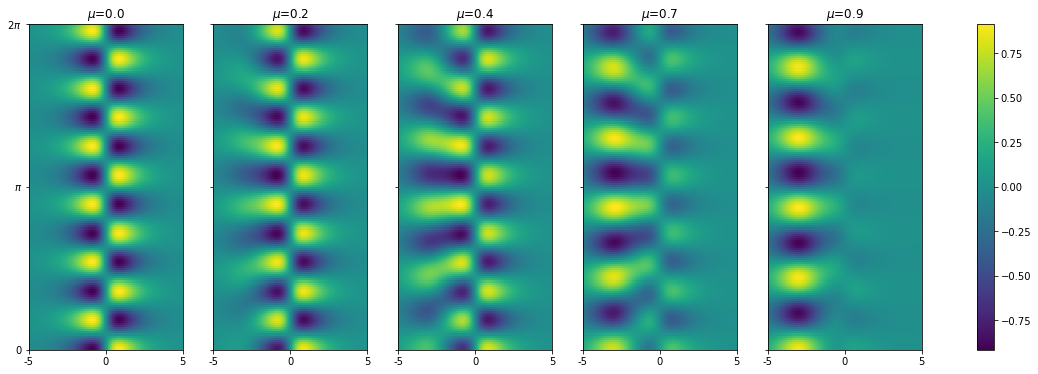

In [6]:
idxes = [0,2,4,6,8]
visualize_multiple(training_snapshots[idxes], training_params[idxes])

As you can see the parameter is 1-dimensional, but the approach works also with parameters living in multi-dimensional spaces. It is important to provide a sufficient number of _training_ parameters, otherwise the algorithm won't be able to explore the solution manifold in an acceptable way.

We now select several _unknown_ (or _testing_) parameters in order to assess the results obtained using the parametric approach. As you can see we consider testing parameters having dishomogeneous distances from our training parameters.

(80,)


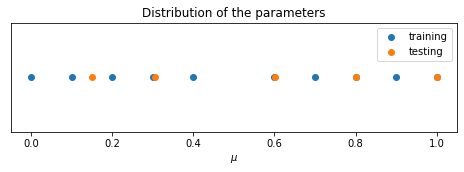

In [7]:
similar_testing_params = [1,3,5,7,9]
testing_params = training_params[similar_testing_params] + np.array([5*pow(10,-i) for i in range(2,7)])

step = t[1]-t[0]
N_predict = 40
N_nonpredict = 40

t2 = np.array([4*np.pi + i*step for i in range(-N_nonpredict+1,N_predict+1)])
print(t2.shape)
xgrid2, tgrid2 = np.meshgrid(x, t2)

testing_snapshots = np.array([f(p)(xgrid2, tgrid2) for p in testing_params])

plt.figure(figsize=(8,2))
plt.scatter(training_params, np.zeros(len(training_params)), label='training')
plt.scatter(testing_params, np.zeros(len(testing_params)), label='testing')
plt.legend()
plt.title('Distribution of the parameters');
plt.xlabel('$\mu$')
plt.yticks([],[]);

## Mathematical formulation

The reference mentioned above proposes two possible ways to achieve the parametrization of DMD, namely _monolithic_ and _partitioned_ approach. We briefly present each one before demonstrating how to use the class `ParametricDMD` in the two cases.

The two methods share a common part, which consists in assembling the matrix
$$\mathbf{X} = \begin{bmatrix}
X_{\mu_1} & \dots & X_{\mu_p}\\
\end{bmatrix} \in \mathbb{R}^{m \times N p}$$ 
where $\mu_1, \dots, \mu_p$ are the parameters in the training set, $X_{\mu_i} \in \mathbb{R}^{m \times N}$ is the set of $N$ snapshots of the time-dependent system computed with the parameter $\mu_i$ represented by a vector with $m$ components (which may be a sampling of a continuous distribution like the pressure field on a surface). In our formulation $m$ is the dimension of the space and $N$ is the number of known time instants for each instance of the parametric problem.

The dimensionality of the problem is reduced using Proper Orthogonal Decomposition (POD) (retaining the first $n$ POD modes using the singular values criteria), thus obtaining the (reduced) matrix
$$\tilde{\mathbf{X}} = \begin{bmatrix}
\tilde{X}_{\mu_1} & \dots & \tilde{X}_{\mu_p}\\
\end{bmatrix} \in \mathbb{R}^{n \times N p}$$

We now examine two ways to treat the reduced matrices $\tilde{X}_{\mu_1}, \dots, \tilde{X}_{\mu_p}$ to obtain an approximation of the system for untested parameters and future time instants.

## Monolithic approach

This method consists in the application of a single DMD altogether to the matrix
$$\begin{bmatrix}
\tilde{X}_{\mu_1}, \dots, \tilde{X}_{\mu_p}
\end{bmatrix}^T \in \mathbb{R}^{np \times N}$$
Note that the index of the time instant increases along the rows of this matrix.

For this reason the constructor requires, in this case, only one instance of `DMD`, since the reduced representations of the snapshots in the testing dataset are treated as one single time-dependent non-parametric system.

This allows us to obtain an approximation of the POD coefficients for the parameters in the training set in future time instants. The POD coefficients are then interpolated separately for each unknown parameter, and the approximated full-dimensional system is reconstructed via a matrix multiplication with the matrix of POD modes.

We choose to retain the first 10 POD modes for each parameter, and set `svd_rank=-1` for our DMD instance, in order to protect us from divergent DMD modes which may ruin the results. We also provide an instance of an `RBF` interpolator to be used for the interpolation of POD coefficients.

In [8]:
pdmd = ParametricDMD(DMD(svd_rank=-1), POD(rank=20), RBF())
pdmd.fit(training_snapshots, training_params)

We can now set the testing parameters by chaning the propery `parameters` of our instance of `ParametricDMD`, as well as the time-frame via the property `dmd_time` (see the other tutorials for an overview of the latter):

In [9]:
pdmd.parameters = testing_params
pdmd.dmd_time['t0'] = pdmd.original_time['tend'] - N_nonpredict + 1
pdmd.dmd_time['tend'] = pdmd.original_time['tend'] + N_nonpredict
print(len(pdmd.dmd_timesteps), pdmd.dmd_timesteps)

80 [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199]


In [10]:
approximation = pdmd.reconstructed_data
approximation.shape

(5, 80, 500)

As you can see above we stored the result of the approximation (which comprises both reconstrction of known time instants and prediction of future time instants) into the variable `approximation`.

Approximation


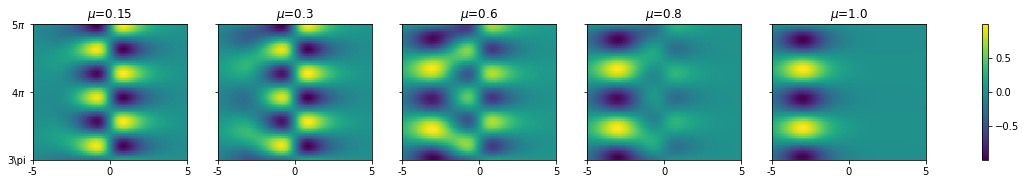

Truth


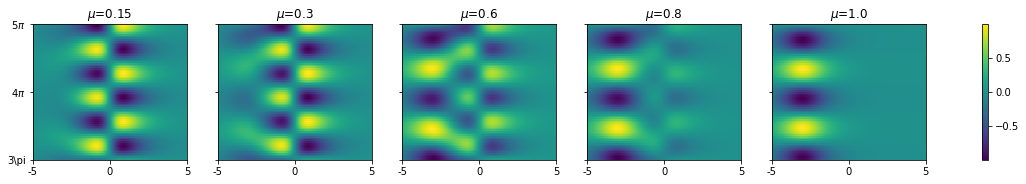

Absolute error


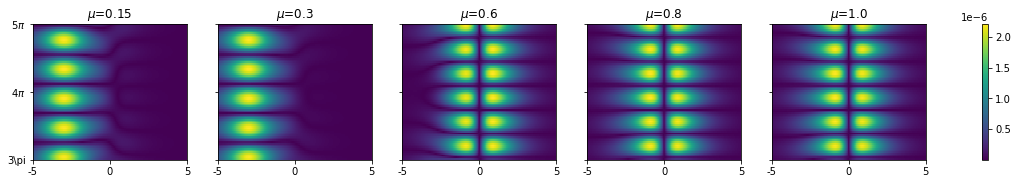

In [11]:
# this is needed to visualize the time/space in the appropriate way
def labels_func(ax):
    l = len(pdmd.dmd_timesteps)
    
    ax.set_yticks([0, l//2, l])
    ax.set_yticklabels(['3\pi', '4$\pi$', '5$\pi$'])

    ax.set_xticks([0, m//2, m])
    ax.set_xticklabels(['-5', '0', '5'])

print('Approximation')
visualize_multiple(approximation, testing_params, figsize=(20,2.5), labels_func=labels_func)
print('Truth')
visualize_multiple(testing_snapshots, testing_params, figsize=(20,2.5), labels_func=labels_func)
print('Absolute error')
visualize_multiple(np.abs(testing_snapshots.real - approximation.real), 
                   testing_params, figsize=(20,2.5), labels_func=labels_func)

Below we plot the dependency of the mean point-wise error of the reconstruction on the distance between the (untested) parameter and the nearest tested parameter in the training set:

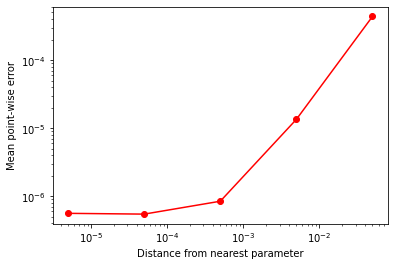

In [12]:
distances = np.abs(testing_params - training_params[similar_testing_params])
errors = np.mean(np.abs(testing_snapshots.real - approximation.real), axis=(1,2))

plt.loglog(distances, errors, 'ro-')
plt.xlabel('Distance from nearest parameter')
plt.ylabel('Mean point-wise error');

## Partitioned approach

We now consider the second possible approach implemented in `ParametricDMD`. We consider again the matrices $\tilde{X}_{\mu_1}, \dots, \tilde{X}_{\mu_p}$ which we defined in [Mathematical formulation](#Mathematical-formulation). Unlke we did for the *Monolithic* approach, we now perform $p$ separate DMDs, one for each $X_{\mu_i}$. We then predict the POD coefficients in future time instants. The reconstruction phase then is the same we performed in the monolithic approach, for the details see the reference mentioned in the introduction.

In order to apply this approach in `PyDMD`, you just need to pass a list of DMD instances in the constructor of `ParametricDMD`. Clearly you will need $p$ instances, where $p$ is the number of parameters in the training set.

In [13]:
dmds = [DMD(svd_rank=-1) for _ in range(len(training_params))]

p_pdmd = ParametricDMD(dmds, POD(rank=20), RBF())
p_pdmd.fit(training_snapshots, training_params)

We set untested parameters and the time frame in which we want to reconstruct the system in the same way we did in the monolithic approach: 

In [14]:
# setting unknown parameters and time
p_pdmd.parameters = testing_params
p_pdmd.dmd_time['t0'] = p_pdmd.original_time['tend'] - N_nonpredict + 1
p_pdmd.dmd_time['tend'] = p_pdmd.original_time['tend'] + N_nonpredict

**Important**: Don't pass the same DMD instance $p$ times, since that would mean that this object is trained $p$ times on $p$ different training set, therefore only the last one is retained at the time in which the reconstruction is computed.

In [15]:
approximation = p_pdmd.reconstructed_data
approximation.shape

(5, 80, 500)

Below we plot the point-wise absolute error:

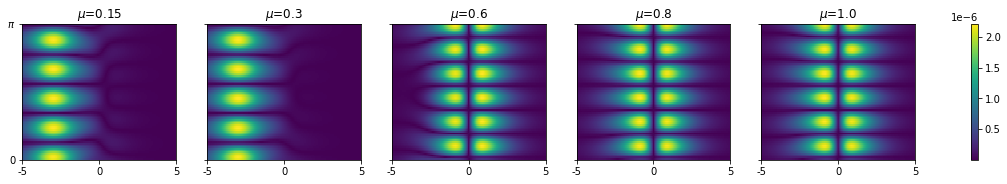

In [16]:
visualize_multiple(np.abs(testing_snapshots.real - approximation.real), testing_params, figsize=(20,2.5))

As you can see there's not much difference in the absolute error, but for more complex problems (i.e. when new frequencies/modes turn on or off as the parameter moves in the domain) there are documented improvements when using the partitioned approach.